# Born test

Detail: Program to test the Born's rule on a quantum computer, using Rigetti's pyQuil platform and Aspen-9 quantum computer.

Author of the code: Simanraj Sadana

Email: simanrajsadana@gmail.com

## Importing libraries

In [67]:
# Importing essential libraries
import numpy as np, matplotlib.pyplot as plt, random, time
from functools import lru_cache
from pyquil import Program, get_qc
from pyquil.gates import *
import os
from pyquil.quilatom import quil_sin, quil_cos, Parameter
from pyquil.quilbase import DefGate
from pyquil.latex import display, to_latex
# import Peres_helpers as hf
import pickle
from collections import Counter
import time

## Generating random angles

In [68]:
# Number of shots and z-score for confidence interval
N_SHOTS = 10_000
Z_SCORE = 3

# Generating random angles
e=0
def params_complex():
	'''
	Generates parameters to prepare COMPLEX quantum states.
    
    Returns:
        A list of three tuples. The first element of each tuple is the value of theta 
        and the second element is the value of phi.
    
	'''
	theta = np.arccos(np.cos(e) - 2 * np.array([random.uniform(0,1) for _ in range(2)]))
	phi = np.array([2*np.pi*random.uniform(0,1) for _ in range(2)])
	params = zip(theta, phi)
	return list(params)

## Circuit construction

In [69]:
# Combined circuit for creating and projecting 3-level states
def circuit_123(a,b):
    '''
    Constructs a parametric circuit required for Sorkin's test.
    
    Input:
    a, b: Qubit numbers which are chosen for the circuit.
    
    Output:
    circ: The circuit object.
    '''
    circ = Program()
    
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    t = circ.declare('t', 'REAL', 2)
    c = circ.declare('ro', 'BIT', 2)
    
    circ += RY(theta[0], a)
    circ += RZ(phi[0], a)
    
    circ += RY(theta[1], b)
    circ += RZ(phi[1]/2, b)
    
    circ += CNOT(a, b)
    
    circ += RZ(-phi[1]/2, b)
    circ += RY((t[1]-theta[1])/2, b)
    
    circ += CNOT(a,b)
    
    circ += RY((-theta[1] - t[1])/2, b)
    
    circ += RY(-t[0], a)
    
    circ += X(a)
    
    circ += MEASURE(a, c[0])
    circ += MEASURE(b, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

## Theoretical probabilities

In [70]:
# The theoretical probabilities and kappa
def theoretical_probs(u):
    '''
    Returns the theoretical probabilities of projective measurements required for Sorkin's test 
    based on the random state chosen.
    
    Input:
    u: A list [(theta_1, phi_1), (theta_2, phi_2)] that are generated randomly.
    
    Output:
    probs: A dictionary of the probabilities of the required projections and the theoretical value of 
    kappa.
    '''
    theta, phi = [], []
    for i in range(len(u)):
        theta.append(u[i][0])
        phi.append(u[i][1])
        
    probs = {
        'P_123': (1/3) * np.abs(np.cos(theta[0]/2)*np.exp(-1j*phi[0]/2) + np.sin(theta[0]/2)*np.cos(theta[1]/2)*np.exp(-1j*(phi[1]-phi[0])/2) + np.sin(theta[0]/2)*np.sin(theta[1]/2)*np.exp(1j*(phi[1]+phi[0])/2))**2, 
        'P_12': (1/2) * np.abs(np.cos(theta[0]/2)*np.exp(-1j*phi[0]/2) + np.sin(theta[0]/2)*np.cos(theta[1]/2)*np.exp(-1j*(phi[1]-phi[0])/2))**2, 
        'P_23': (1/2) * np.abs(np.sin(theta[0]/2)*np.cos(theta[1]/2)*np.exp(-1j*(phi[1]-phi[0])/2) + np.sin(theta[0]/2)*np.sin(theta[1]/2)*np.exp(1j*(phi[1]+phi[0])/2))**2, 
        'P_31': (1/2) * np.abs(np.cos(theta[0]/2)*np.exp(-1j*phi[0]/2) + np.sin(theta[0]/2)*np.sin(theta[1]/2)*np.exp(1j*(phi[1]+phi[0])/2))**2, 
        'P_1': np.cos(theta[0]/2)**2,
        'P_2': np.sin(theta[0]/2)**2 * np.cos(theta[1]/2)**2,
        'P_3': np.sin(theta[0]/2)**2 * np.sin(theta[1]/2)**2,
    }
    
    probs['Kappa'] = 3 * probs['P_123'] - 2 * (probs['P_12'] + probs['P_23'] + probs['P_31']) + probs['P_1'] + probs['P_2'] + probs['P_3']
    
    return probs

## Theoretical fluctuations due to limited shots

In [129]:
# Getting the theoretical fluctuations with 1000 repetitions of the same circuit
ci_a = 0.005
ci_b = 1 - ci_a
def get_ci(states):
    ci_list = []
    v_list = []
    for state in states:
        probs = theoretical_probs(state['State_params'])
        k_list = []
        for i in range(1000):
            c123 = Counter(random.choices(['0','1'], weights=[probs['P_123'], 1-probs['P_123']], k=N_SHOTS))['0']
            c12 = Counter(random.choices(['0','1'], weights=[probs['P_12'], 1-probs['P_12']], k=N_SHOTS))['0']
            c23 = Counter(random.choices(['0','1'], weights=[probs['P_23'], 1-probs['P_23']], k=N_SHOTS))['0']
            c31 = Counter(random.choices(['0','1'], weights=[probs['P_31'], 1-probs['P_31']], k=N_SHOTS))['0']
            csingles = Counter(random.choices(['0','1','2'], weights=[probs['P_1'], probs['P_2'], probs['P_3']], k=N_SHOTS))

            k = 3*c123 - 2*(c12+c23+c31) + csingles['0'] + csingles['1'] + csingles['2']
            k_list.append(k/10_000)
        
        k_list.sort()
#         ci = [k_list[int(ci_a*len(k_list))], k_list[int(ci_b*len(k_list)) - 1]]#
        ci = [k_list[int(0+ci_a*len(k_list))], k_list[int(len(k_list) - 1 - ci_a*len(k_list))]]
        # ci = [k_list[int(0.00*len(k_list))], k_list[int(1*(len(k_list)-1))]]
        ci_list.append(ci)
        state['Theory'] = {}
        state['Theory']['k'] = (ci[0] + ci[1])/2
        state['Theory']['ci'] = ci
        v_list.append(max(k_list))

    return states

## Bootstrapped CI for results from circuit-runs

In [72]:
# Getting bootstrapped confidence intervals of the circuit outcomes
def get_boot_ci(states, engine):
    for state in states:
        k_boot = []
        for i in range(1000):
            sample_123 = state[engine]['Clicks_123']
            sample_12 = state[engine]['Clicks_12']
            sample_23 = state[engine]['Clicks_23']
            sample_31 = state[engine]['Clicks_31']
            sample_Singles = state[engine]['Clicks_Singles']

            counts_123 = Counter(np.random.choice(sample_123, len(sample_123)))
            counts_12 = Counter(np.random.choice(sample_12, len(sample_12)))
            counts_23 = Counter(np.random.choice(sample_23, len(sample_23)))
            counts_31 = Counter(np.random.choice(sample_31, len(sample_31)))
            counts_Singles = Counter(np.random.choice(sample_Singles, len(sample_Singles)))


            k = 3*counts_123['10'] - 2*(counts_12['10'] + counts_23['10'] + counts_31['10']) + counts_Singles['00'] + counts_Singles['01'] + counts_Singles['10']
            k = k/N_SHOTS
            k_boot.append(k)

        k_boot.sort()

    #     state[engine]['Result']['g12']['ci']
        state[engine]['k']['ci'] =[k_boot[int(0+ci_a*len(k_boot))], k_boot[int(len(k_boot) - 1 - ci_a*len(k_boot))]]

    #     state[engine]['CI'] = {'g12': g12_cf, 'g23': g23_cf, 'g31': g31_cf, 'f': f_cf, 'k': k_cf}

        print(f'Done with state no. {states.index(state)}', end='\r')
    return states


## Function for getting good qubits

In [73]:
# Getting good qubits and edges
def get_good_qbits(cz_fid, meas_fid):
    '''
    Finds the best pair of qubits given the lower-bound on the fidelities of CZ and MEASURE operation.
    
    Input: 
    cz_fid: The lower-bound on fidelity of CZ gate
    meas_fid: The lower-bound on fidelity of MEASURE operation
    
    Output:
    good_qubits: A list of good qubits with details of fidelities.
    
    '''
    # Initialise Aspen-9 machine
    qc = get_qc('Aspen-9')
    
    # Get the details of qubits and edges
    details = qc.device.get_isa()

    good_edges = [] # To store the details of good qubits.
    
    # Looping through all the edges to find the edge with max-fidelity CZ-gate
    for edge in details.edges:
        # Getting the list of gates supported by the edge
        gates = edge.gates
        # Looping through the list of gates
        for gate in gates:
            # Picking the CZ gate
            if gate.operator == 'CZ':
                # Checking if the gate-fidelity is above the threshold.
                # The try-except statement will prevent the program from terminating if CZ is not supported by the edge.
                try:
                    if gate.fidelity > cz_fid:
                        good_edges.append(edge)
                except TypeError:
                    continue
    good_qubits = {} # A dictionary to store the details of good qubits in organised form
    
    # Looping through the list of good edges to pick the ones with qubits with MEASURE-fidelity above the threshold.
    for edge in good_edges[:]:
        # Getting the qubit objects from the edge object so that we check only those qubits for which the edge satisfies the condition
        q1, q2 = edge.targets
        # Looping through the list of qubits available
        for q in details.qubits:
            # Checking if the qubit is present in the list of good edges
            if q.id in [q1,q2]:
                # Getting the list of gates supported by the chosen qubit
                gates = q.gates
                # Looping through the list of gates.
                for gate in gates:
                    # Picking the MEASURE gate
                    if gate.operator == 'MEASURE':
                        # Checking if the measure-fidelity is below the threshold.
                        # If yes, then the corresponding edge is removed from the list of good edges, leaving only the good-qubit-edges.
                        if gate.fidelity < meas_fid:
                            try:
                                good_edges.remove(edge)
                            except ValueError:
#                                 print('Edge already removed')
                                continue
    good_qubits = [] # To store the good qubits with details.
    
    # Looping through the list of good-edges
    for edge in good_edges:
        # Getting the target qubits of the corresponding edge
        q1, q2 = edge.targets
        # Storing the details of the edge in dictionary form.
        good_qubits.append({'Edge': edge})
        
        # Storing the details of the qubits in dictionary form.
        for q in details.qubits:
            if q.id == q1:
                good_qubits[-1]['Qubit1'] = q
            elif q.id == q2:
                good_qubits[-1]['Qubit2'] = q
    return good_qubits

## Getting good qubits and edges

In [111]:
# Get the good qubits
good_bits = get_good_qbits(0.96, 0.96)#(0.97, 0.96)

# Displaying the details of the gate fidelities of the returned qubits.
for bits in good_bits:
    print(bits['Edge'].targets)
    print(bits['Qubit1'].gates[0])
    print(bits['Qubit2'].gates[0])
    print(bits['Edge'].gates[0], end='\n\n')

(21, 36)
MeasureInfo(operator='MEASURE', qubit=21, target='_', duration=2000, fidelity=0.973)
MeasureInfo(operator='MEASURE', qubit=36, target='_', duration=2000, fidelity=0.9620000000000001)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9736065352398284)

(35, 36)
MeasureInfo(operator='MEASURE', qubit=35, target='_', duration=2000, fidelity=0.968)
MeasureInfo(operator='MEASURE', qubit=36, target='_', duration=2000, fidelity=0.9620000000000001)
GateInfo(operator='CZ', parameters=[], arguments=['_', '_'], duration=200, fidelity=0.9716099672423921)



## Choosing from the list of good qubits

In [112]:
good_qubits = good_bits[0]

## Generating a list of random states

In [130]:
with open('state_params_3_with_aspen.pkl', 'rb') as file:
    good_qubits, states = pickle.load(file)
# Generate random states
# states = [{'State_params': params_complex()} for _ in range(10)]
# with open('state_params_3.pkl', 'wb') as file:
#     pickle.dump((good_qubits, states), file)
states = get_ci(states)

## Getting the theoretical values and fluctuations from probability functions

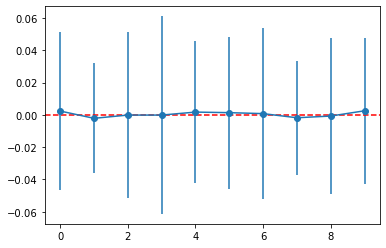

In [118]:
x = np.arange(len(states))
y = np.array([states[i]['Theory']['k'] for i in range(len(states))])
yerr = np.array([states[i]['Theory']['ci'] for i in range(len(states))])

plt.errorbar(x, y, yerr=[y - yerr[:,0], yerr[:,1] - y], marker='o')
plt.axhline(y=0, ls='dashed', color='red')

## Function for running the circuit

In [93]:
def run_circuit(states, engine):
    '''
    Compile and run the circuit given the parameters. The list of outputs is returned.
    '''
    for state in states:
        state[engine] = {}
        theta, phi = tuple(map(list, zip(*state['State_params'])))
   
        t = [2 * np.arccos(1/np.sqrt(3)), 2 * np.arccos(1/np.sqrt(2))]
        clicks = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 't': t}) # Stores the output of the circuit run.
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_123'] = np.array(clicks)
        state[engine]['Counts_123'] = Counter(clicks)['10']
#         outcomes['P_123'] = Counter(tmp)['00']

        t = [np.pi/2, 0]
        clicks = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 't': t}) # Stores the output of the circuit run.
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_12'] = np.array(clicks)
        state[engine]['Counts_12'] = Counter(clicks)['10']
#         outcomes['P_12'] = Counter(tmp)['00']

        t = [np.pi, np.pi/2]
        clicks = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 't': t}) # Stores the output of the circuit run.
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_23'] = np.array(clicks)
        state[engine]['Counts_23'] = Counter(clicks)['10']
#         outcomes['P_23'] = Counter(tmp)['00']

        t = [np.pi/2, np.pi]
        clicks = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 't': t}) # Stores the output of the circuit run.
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_31'] = np.array(clicks)
        state[engine]['Counts_31'] = Counter(clicks)['10']
#         outcomes['P_31'] = Counter(tmp)['00']

        t = [0, 0]
        clicks = qc.run(exe, memory_map={'theta': theta, 'phi': phi, 't': t})
        clicks = [''.join(list(map(str, x))) for x in clicks]
        state[engine]['Clicks_Singles'] = np.array(clicks)
        state[engine]['Counts_Singles'] = Counter(clicks)
#         outcomes['Singles'] = Counter(tmp)
        state[engine]['k'] = {}
        state[engine]['k']['val'] = (3*state[engine]['Counts_123'] - 2*(state[engine]['Counts_12']+state[engine]['Counts_23']+state[engine]['Counts_31']) + state[engine]['Counts_Singles']['00'] + state[engine]['Counts_Singles']['10'] + state[engine]['Counts_Singles']['01']) / N_SHOTS
    
    return states

## Initialising the circuit

In [132]:
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id # Qubit IDs
print(f'Qubits used are {q1} and {q2}')
engine = '2q-qvm'
# engine = 'Aspen-9'
print(f'Engine used: {engine}')

circ = circuit_123(q1,q2)
qc = get_qc(engine)
exe = qc.compile(circ)

Qubits used are 21 and 36
Engine used: 2q-qvm


## Running the circuit

In [186]:
states = run_circuit(states, engine)

In [116]:
# with open('state_params_3_with_aspen.pkl', 'wb') as file:
#     pickle.dump((good_qubits, states), file)

## Getting bootstrapped CIs of the result

In [211]:
#states = get_boot_ci(states, engine)
states = get_boot_ci(states, 'Aspen-9')

## Plotting the results

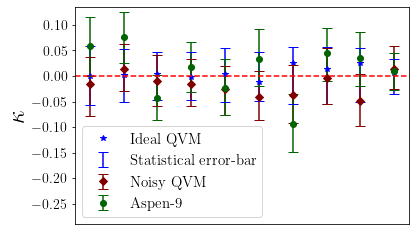

In [222]:
kth = np.array([states[i]['Theory']['k'] for i in range(len(states))])
kthci = np.array([states[i]['Theory']['ci'] for i in range(len(states))])

k2q = np.array([states[i]['2q-qvm']['k']['val'] for i in range(len(states))])
# k2qci = np.array([states[i]['2q-qvm']['k']['ci'] for i in range(len(states))])

kas = np.array([states[i]['Aspen-9']['k']['val'] for i in range(len(states))])
kasci = np.array([states[i]['Aspen-9']['k']['ci'] for i in range(len(states))])

knq = np.array([states[i]['noisy-2q-qvm']['k']['val'] for i in range(len(states))])
knqci = np.array([states[i]['noisy-2q-qvm']['k']['ci'] for i in range(len(states))])

x = np.arange(len(states))

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Helvetica"]})

plt.plot(x, k2q, '*', color="blue", label='Ideal QVM')
plt.errorbar(x, kth, yerr=[kth - kthci[:,0], kthci[:,1] - kth], ls='', capsize=5, color='blue', label='Statistical error-bar')
# plt.errorbar(x, k2q, yerr=[k2q - k2qci[:,0], k2qci[:,1] - k2q], marker='o', ls='', capsize=4)
plt.errorbar(x, knq, yerr=[knq - knqci[:,0], knqci[:,1] - knq], marker='D', ls='', capsize=5, color='maroon', label='Noisy QVM')

plt.errorbar(x, kas, yerr=[kas - kasci[:,0], kasci[:,1] - kas], marker='o', ls='', capsize=5, color='darkgreen', label='Aspen-9')

# plt.plot(x, kas, 'o', color='darkgreen')

plt.axhline(y=0, ls='dashed', color='red')
plt.xticks([])
# plt.plot(x, k2q, 'o')

plt.yticks(size=14)
plt.ylabel('$\kappa$', size=24)

plt.legend(fontsize=15)
plt.ylim([-0.29, 0.135])

plt.savefig('24_oct_Born_plot_for_manuscript.pdf', bbox_inches='tight')
# used 0.5 for manuscript
plt.show()

## states[0]

In [48]:
# with open('24_Oct_Born_run_1_Simulation.pkl', 'wb') as file:
#     pickle.dump((good_qubits, states), file)

# Running on Noisy QVM

In [145]:
# Amplitude damping functions
def damping_channel(damp_prob):
    """
    Generate the Kraus operators corresponding to an amplitude damping
    noise channel.

    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])

    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.

    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]


def append_damping_to_gate(gate, damp_prob):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by an amplitude damping noise channel.

    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return append_kraus_to_gate(damping_channel(damp_prob), gate)


# Dephasing noise model
def dephasing_kraus_map(p=.1):
    """
    Generate the Kraus operators corresponding to a dephasing channel.

    :params float p: The one-step dephasing probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return [np.sqrt(1-p)*np.eye(2), np.sqrt(p)*np.diag([1, -1])]

def tensor_kraus_maps(k1, k2):
    """
    Generate the Kraus map corresponding to the composition
    of two maps on different qubits.

    :param list k1: The Kraus operators for the first qubit.
    :param list k2: The Kraus operators for the second qubit.
    :return: A list of tensored Kraus operators.
    """
    return [np.kron(k1j, k2l) for k1j in k1 for k2l in k2]


In [148]:
# Combined circuit for creating and projecting 3-level states
def circuit_123_noisy(a, b, p, pmeas_1, pmeas_2, damping_per_I):
    circ = Program()
    
    theta = circ.declare('theta', 'REAL', 2)
    phi = circ.declare('phi', 'REAL', 2)
    t = circ.declare('t', 'REAL', 2)
    c = circ.declare('ro', 'BIT', 2)
    
    corrupted_CZ = append_kraus_to_gate(
    tensor_kraus_maps(
        dephasing_kraus_map(p),
        dephasing_kraus_map(p)
    ),
    np.diag([1, 1, 1, -1]))
    
    circ.define_noisy_gate("CZ", [a, b], corrupted_CZ)
    
    circ.define_noisy_readout(a, p00=pmeas_1[0], p11=pmeas_1[1])
    circ.define_noisy_readout(b, p00=pmeas_2[0], p11=pmeas_2[1])
    
    circ.define_noisy_gate("I", [a], append_damping_to_gate(np.eye(2), damping_per_I))
    circ.define_noisy_gate("I", [b], append_damping_to_gate(np.eye(2), damping_per_I))
    
    circ += RY(theta[0], a)
    circ += RZ(phi[0], a)
    
    circ += RY(theta[1], b)
    circ += RZ(phi[1]/2, b)
    
    circ += CNOT(a, b)
    
    circ += RZ(-phi[1]/2, b)
    circ += RY((t[1]-theta[1])/2, b)
    
    circ += CNOT(a,b)
    
    circ += RY((-theta[1] - t[1])/2, b)
    
    circ += RY(-t[0], a)
    
    circ += X(a)
    
    circ += I(a)
    circ += I(b)
    
    circ += MEASURE(a, c[0])
    circ += MEASURE(b, c[1])
    
    circ.wrap_in_numshots_loop(N_SHOTS)
    
    return circ

In [185]:
# Details of circuit-run
q1, q2 = good_qubits['Qubit1'].id, good_qubits['Qubit2'].id # Qubit IDs
print(q1,q2)

deph_damp = 1-good_qubits['Edge'].gates[0].fidelity
pmeas_1 = [good_qubits['Qubit1'].gates[0].fidelity, good_qubits['Qubit1'].gates[0].fidelity]
pmeas_2 = [good_qubits['Qubit2'].gates[0].fidelity, good_qubits['Qubit2'].gates[0].fidelity]


# Details of the device on which to run the circuit
engine = 'noisy-2q-qvm' # Choosing between simulator and Aspen-9 computer
qc = get_qc('2q-qvm') # Initialising the device
print(qc) # Display device details
circ = circuit_123_noisy(q1,q2, deph_damp, pmeas_1, pmeas_2, 0.5)
exe = qc.compile(circ)

21 36
2q-qvm


In [184]:
# with open('state_params_3_with_aspen_and_noise_amp_0.4.pkl', 'wb') as file:
#     pickle.dump((good_bits, states), file)

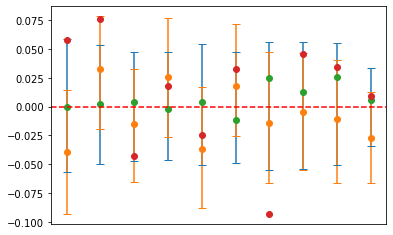

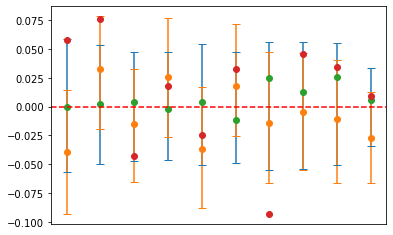

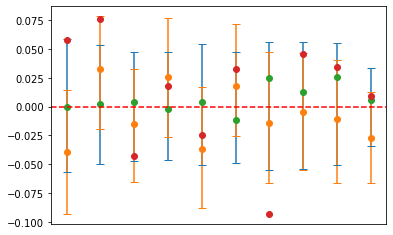

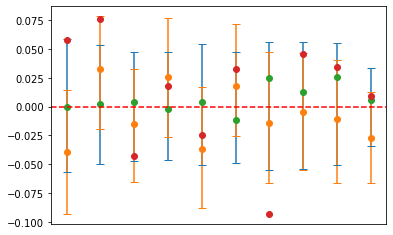

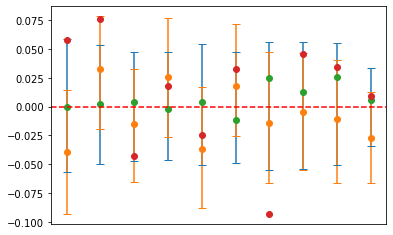

In [190]:
for i in np.arange(0.1, 0.6, 0.1):
    with open(f'state_params_3_with_aspen_and_noise_amp_{np.round(i,1)}.pkl', 'rb') as file:
        gb, st = pickle.load(file)
    
    kth = np.array([states[i]['Theory']['k'] for i in range(len(states))])
    kthci = np.array([states[i]['Theory']['ci'] for i in range(len(states))])

    k2q = np.array([states[i]['2q-qvm']['k']['val'] for i in range(len(states))])
    # k2qci = np.array([states[i]['2q-qvm']['k']['ci'] for i in range(len(states))])

    kas = np.array([states[i]['Aspen-9']['k']['val'] for i in range(len(states))])
    # kasci = np.array([states[i]['Aspen-9']['k']['ci'] for i in range(len(states))])

    knq = np.array([states[i]['noisy-2q-qvm']['k']['val'] for i in range(len(states))])
    knqci = np.array([states[i]['noisy-2q-qvm']['k']['ci'] for i in range(len(states))])

    x = np.arange(len(states))

    plt.errorbar(x, kth, yerr=[kth - kthci[:,0], kthci[:,1] - kth], ls='', capsize=4)
    # plt.errorbar(x, k2q, yerr=[k2q - k2qci[:,0], k2qci[:,1] - k2q], marker='o', ls='', capsize=4)
    # plt.errorbar(x, kas, yerr=[kas - kasci[:,0], kasci[:,1] - kas], marker='o', ls='', capsize=4)
    plt.errorbar(x, knq, yerr=[knq - knqci[:,0], knqci[:,1] - knq], marker='o', ls='', capsize=4)
    plt.plot(x, k2q, 'o')
    plt.plot(x, kas, 'o')

    plt.axhline(y=0, ls='dashed', color='red')
    plt.xticks([])
    # plt.plot(x, k2q, 'o')


    plt.show()


In [206]:
# with open('state_params_3_with_aspen_and_noise_amp_0.5.pkl', 'rb') as file:
#     good_qubits, states = pickle.load(file)